the missing value is on AFRM , it's for the next quarter it's not labeled +1q that's the reason behind that.

In [5]:
import time as _tm
import requests as _rq
import pandas as _pd
import openpyxl
API_TOKEN = "67ffece4b2ae08.94077168"
BASE_URL  = "https://eodhd.com/api"
HEADERS   = {"User-Agent": "EPS-Trend/1.1"}
PAUSE_SEC = 1.1                     


def _get_json(url: str) -> dict:
    r = _rq.get(url, headers=HEADERS, timeout=30)
    r.raise_for_status()
    return r.json()


def _pull_trend(ticker: str) -> dict:

    url = (
        f"{BASE_URL}/fundamentals/{ticker}"
        f"?filter=Earnings::Trend"           
        f"&api_token={API_TOKEN}&fmt=json"
    )
    data = _get_json(url)

    if "Earnings" in data:          
        return data.get("Earnings", {}).get("Trend", {})
    return data                     


def _latest_snapshots(trend: dict) -> dict[str, dict]:
    latest = {}
    for date_str, rec in trend.items():
        p = rec.get("period")
        if not p:
            continue
        ts = _pd.to_datetime(date_str, errors="coerce")
        if p not in latest or ts > latest[p]["_ts"]:
            rec["_ts"] = ts
            latest[p] = rec
    return latest


def _row_for(ticker: str) -> dict:
    trend = _pull_trend(ticker)
    if not trend:
        return {"Ticker": ticker.split('.', 1)[0], "ERROR": "no Trend"}

    snap = _latest_snapshots(trend)

    periods = {
        "Curr Qtr": "0q",
        "Next Qtr": "+1q",
        "Curr Yr":  "0y",
        "Next Yr":  "+1y",
    }

    def val(rec, fld):
        return float(rec.get(fld)) if rec and rec.get(fld) not in (None, "") else None

    row = {"Ticker": ticker.split('.', 1)[0]}
    for label, code in periods.items():
        rec = snap.get(code, {})
        row[f"{label} Curr"] = val(rec, "epsTrendCurrent")
        row[f"{label} 7"]    = val(rec, "epsTrend7daysAgo")
        row[f"{label} 30"]   = val(rec, "epsTrend30daysAgo")
        row[f"{label} 60"]   = val(rec, "epsTrend60daysAgo")
        row[f"{label} 90"]   = val(rec, "epsTrend90daysAgo")
    return row


def build_eps_trends(tickers: list[str]) -> _pd.DataFrame:
    rows = []
    for tk in tickers:
        print(f"{tk} ...", end="", flush=True)
        try:
            rows.append(_row_for(tk))
            print("ok")
        except Exception as e:
            print(f"ERR: {e}")
            rows.append({"Ticker": tk.split('.', 1)[0], "ERROR": str(e)})
        _tm.sleep(PAUSE_SEC)
    return _pd.DataFrame(rows)


def save(df: _pd.DataFrame, fname="eps_trend.csv"):
    if fname.lower().endswith(".xlsx"):
        df.to_excel(fname, index=False, engine="openpyxl")
    else:
        df.to_csv(fname, index=False, encoding="utf-8")
    # print(f"\n✅  Saved {len(df)} rows → {fname}")




In [6]:
if __name__ == "__main__":
    # raw1 = ['uber', 'gm', 'amd', 'intc', 'rddt', 'goog', 'afrm' , 'coin', 'u', 'hsy', 'gis', 'dg', 'asan', 'aapl', 'cvs', 'duol', 'mdb', 'gtlb', 'msft', 'nflx', 'shop', 'snap', 'uber', 'sbux', 'ter', 'dks']
    # raw = [
    #     "NET", "CRS", "ORLY", "DOCN", "TEM", "VST", "CVS", "TER", "RIVN", "NTGR",
    #     "SPOT", "UBER", "SNOW", "ACHR", "ASAN", "RKLB", "DPZ", "LYFT", "NEGG", "MSFT",
    #     "AAPL", "ARM", "AMZN", "META", "NFLX", "NVDA", "GOOG", "RDFN", "MDB", "Z",
    #     "INTC", "AMD", "AFRM", "COIN", "TSLA", "HOOD", "CAVA", "F", "GM", "SMR", "U",
    #     "RDDT", "SHOP", "SOFI"
    # ]
    raw1 = [
    "coin",
    "shop",
    "asan",
    "rddt",
    "ter",
    "hsy",
    "gis",
    "uber",
    "sbux",
    "nflx",
    "gm",
    "goog",
    "gtlb"
]
    tickers = [f"{t}.US" for t in raw1]
    tbl = build_eps_trends(tickers)



coin.US ...ok
shop.US ...ok
asan.US ...ok
rddt.US ...ok
ter.US ...ok
hsy.US ...ok
gis.US ...ok
uber.US ...ok
sbux.US ...ok
nflx.US ...ok
gm.US ...ok
goog.US ...ok
gtlb.US ...ok


In [7]:
display(tbl)
print(tbl.columns)

,Ticker,Curr Qtr Curr,Curr Qtr 7,Curr Qtr 30,Curr Qtr 60,Curr Qtr 90,Next Qtr Curr,Next Qtr 7,Next Qtr 30,Next Qtr 60,...,Curr Yr Curr,Curr Yr 7,Curr Yr 30,Curr Yr 60,Curr Yr 90,Next Yr Curr,Next Yr 7,Next Yr 30,Next Yr 60,Next Yr 90
0,coin,1.4428,1.4428,1.7735,1.7707,1.7429,NaN,NaN,NaN,NaN,...,5.4583,5.4583,7.5178,7.8815,7.5622,7.6342,7.6342,7.9416,8.0437,7.4637
1,shop,0.2857,0.3221,0.3224,0.3237,0.3211,0.3422,0.3635,0.3682,0.3705,...,1.3963,1.4297,1.4829,1.4939,1.5098,1.7976,1.8333,1.8909,1.8980,1.9209
2,asan,0.0196,0.0196,0.0196,0.0203,-0.0134,0.0401,0.0401,0.0407,0.0414,...,0.1920,0.1920,0.1955,0.1944,-0.0052,0.3406,0.3406,0.3443,0.3450,0.1589
3,rddt,0.1816,0.1816,0.1120,0.1370,0.1399,0.3181,0.3196,0.3092,0.3457,...,1.2412,1.2414,1.0236,1.1444,1.1367,2.2680,2.2691,2.0316,2.2769,2.2941
4,ter,0.5377,0.5377,0.5298,0.5376,0.7717,0.8973,0.8973,0.9884,1.0163,...,3.3954,3.3954,3.2681,3.3252,3.9306,4.6000,4.6000,4.9234,5.0184,5.5086
5,hsy,0.9812,0.9812,1.2445,1.2285,1.2246,1.4434,1.4434,1.4967,1.5118,...,5.9724,5.9767,6.0854,6.1231,6.1200,6.2891,6.3118,6.5924,6.6090,6.7988
6,gis,0.9608,0.9749,0.9947,1.0087,1.1511,0.9417,0.9484,0.9654,1.0331,...,4.1814,4.1819,4.1827,4.1980,4.3700,4.0270,4.0304,4.0604,4.1294,4.5005
7,uber,0.6221,0.6206,0.5777,0.5918,0.5915,0.6689,0.6683,0.6455,0.6532,...,2.8383,2.8139,2.4250,2.4459,2.4414,3.4611,3.4418,3.3141,3.3397,3.3449
8,sbux,0.6574,0.6656,0.8523,0.8730,0.8728,NaN,NaN,NaN,NaN,...,2.4638,2.4793,2.8930,2.9516,2.9568,3.0404,3.0592,3.5501,3.6472,3.6610
9,nflx,7.0534,7.0537,6.7757,6.2642,6.2512,6.6262,6.6268,6.8433,7.0016,...,25.5663,25.5728,25.5701,24.7614,24.7159,30.8227,30.7818,30.7787,30.2709,30.2283


Index(['Ticker', 'Curr Qtr Curr', 'Curr Qtr 7', 'Curr Qtr 30', 'Curr Qtr 60',
       'Curr Qtr 90', 'Next Qtr Curr', 'Next Qtr 7', 'Next Qtr 30',
       'Next Qtr 60', 'Next Qtr 90', 'Curr Yr Curr', 'Curr Yr 7', 'Curr Yr 30',
       'Curr Yr 60', 'Curr Yr 90', 'Next Yr Curr', 'Next Yr 7', 'Next Yr 30',
       'Next Yr 60', 'Next Yr 90'],
      dtype='object')


In [9]:
import plotly.graph_objects as go


MU.US ...ok
WDC.US ...ok
STX.US ...ok
MRVL.US ...ok
AVGO.US ...ok
ANET.US ...ok
CSCO.US ...ok
TSM.US ...ok
ASX.US ...ok
VRT.US ...ok
AMZN.US ...ok
MSFT.US ...ok
GOOGL.US ...ok
CDNS.US ...ok
SNPS.US ...ok
ANSS.US ...ok


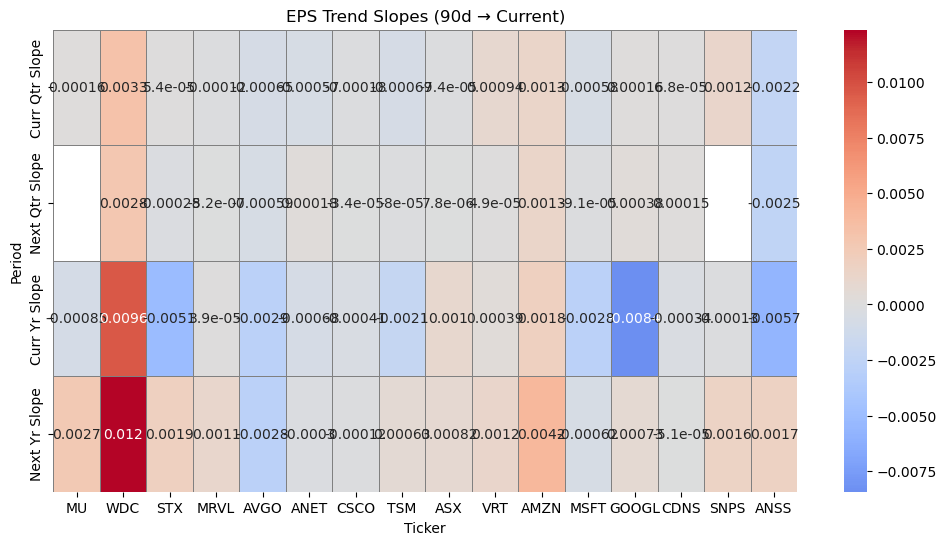

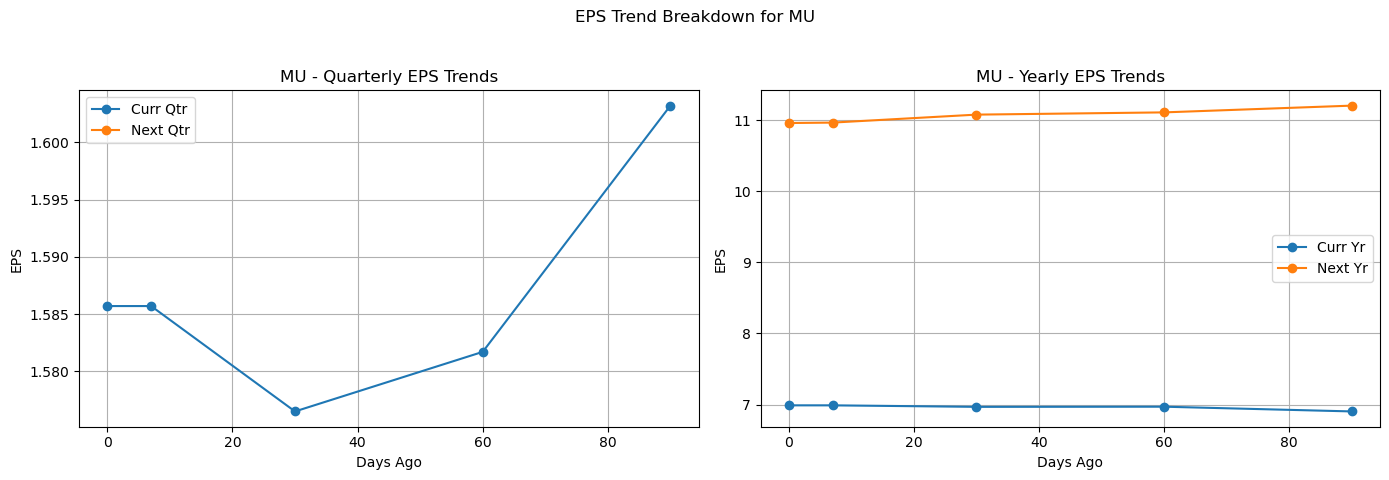

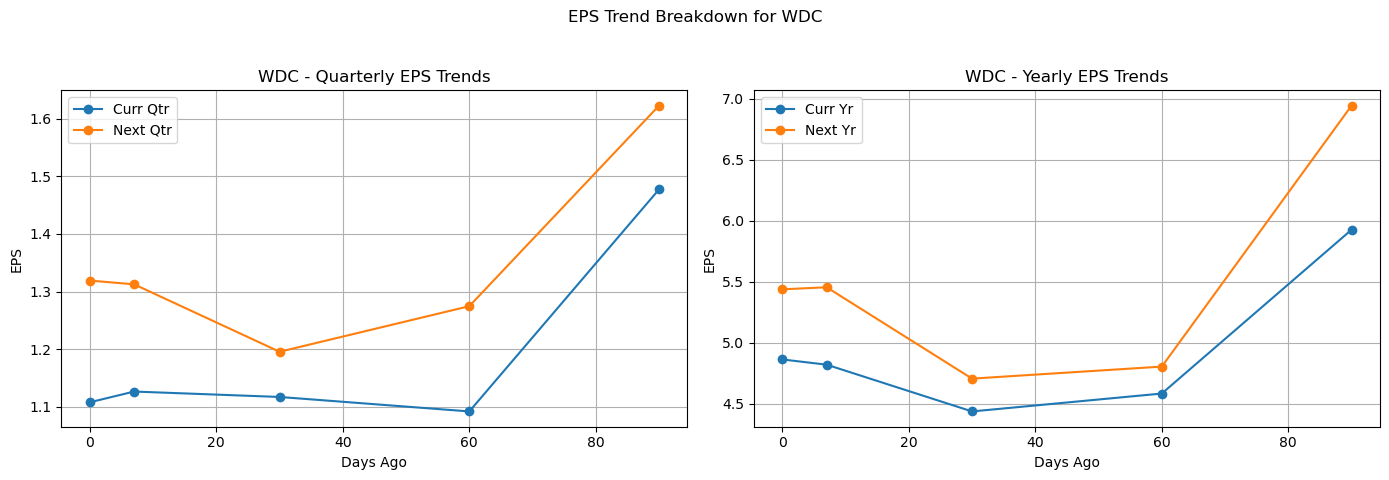

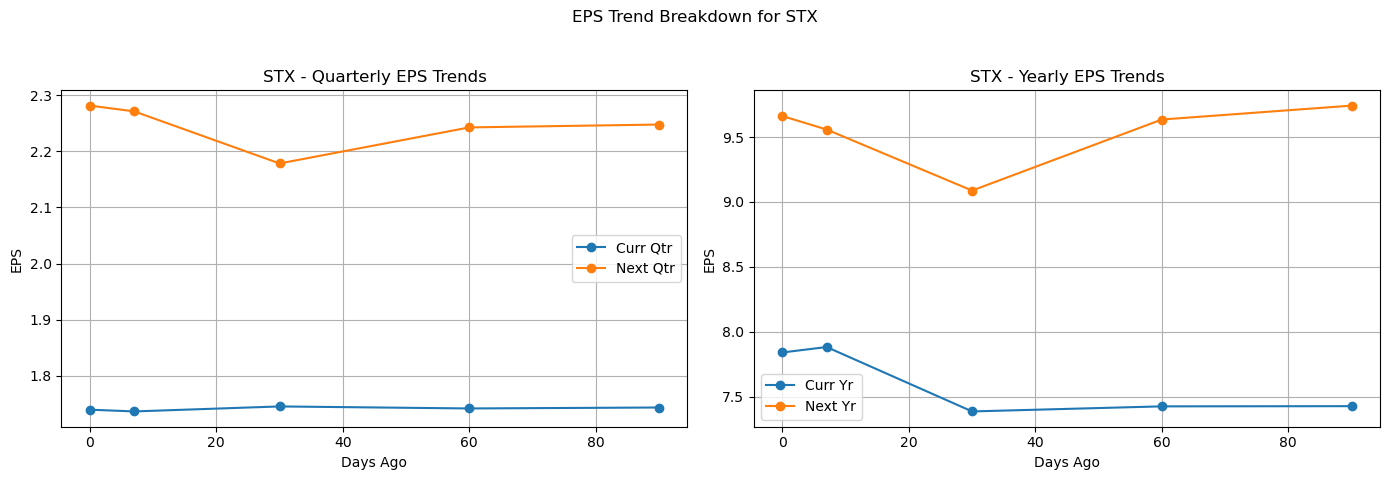

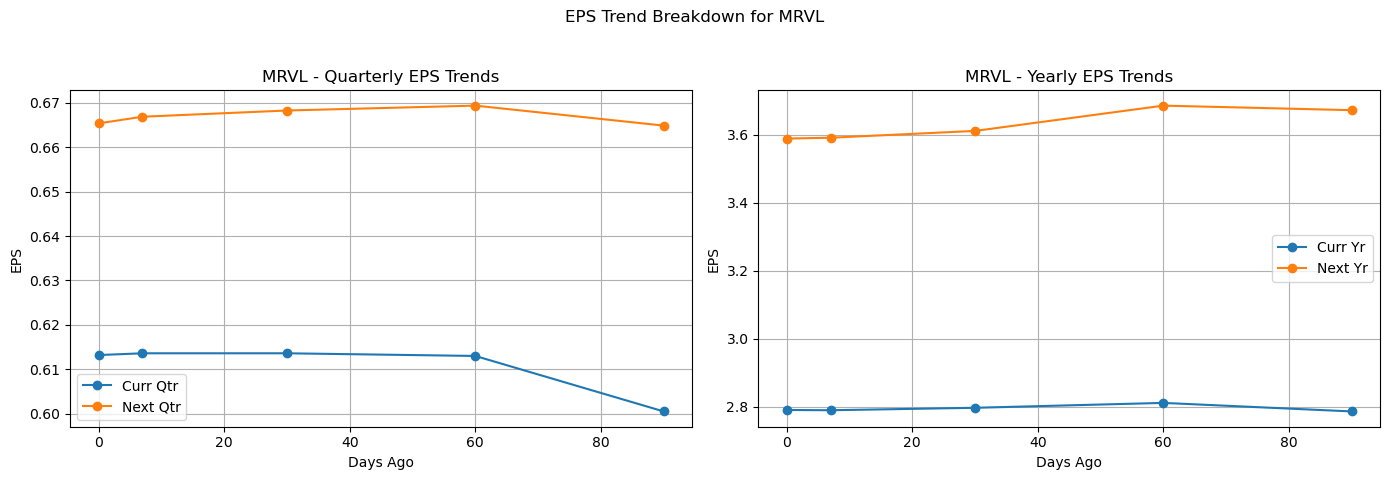

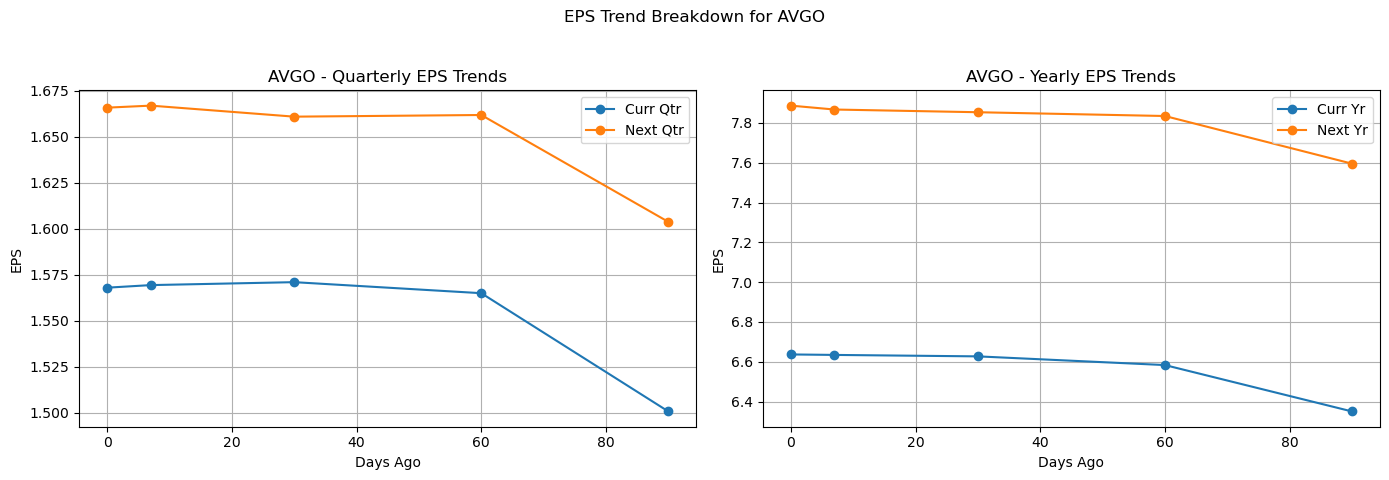

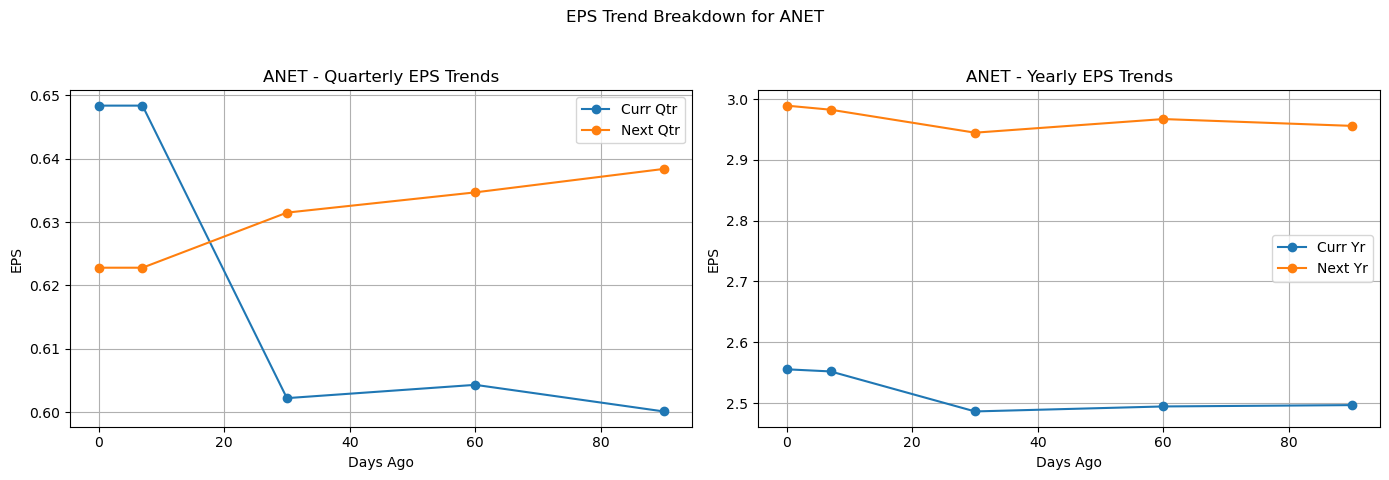

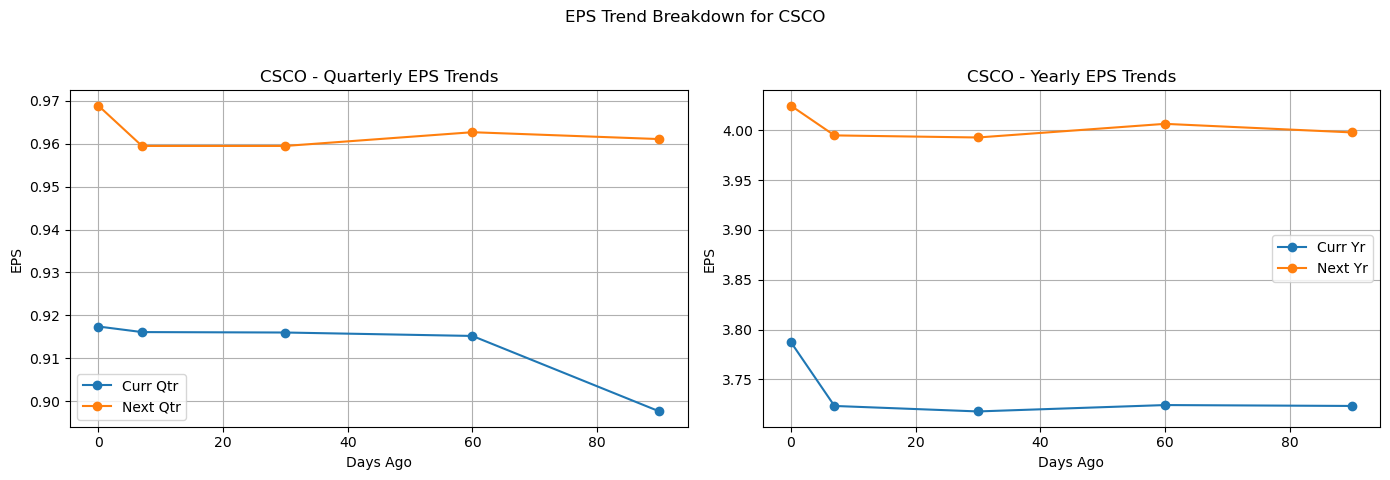

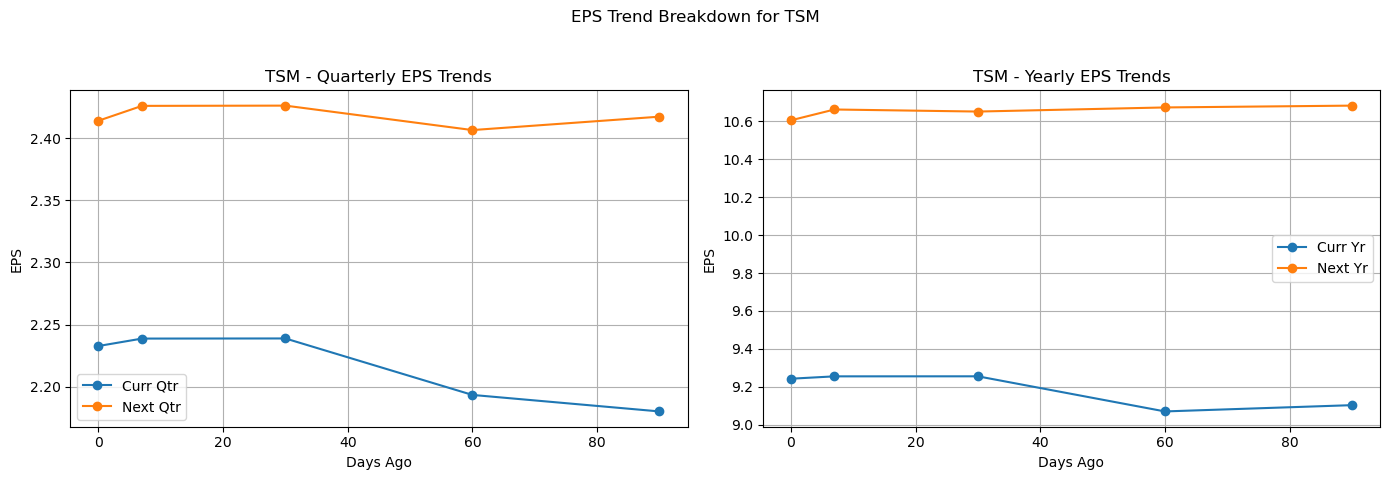

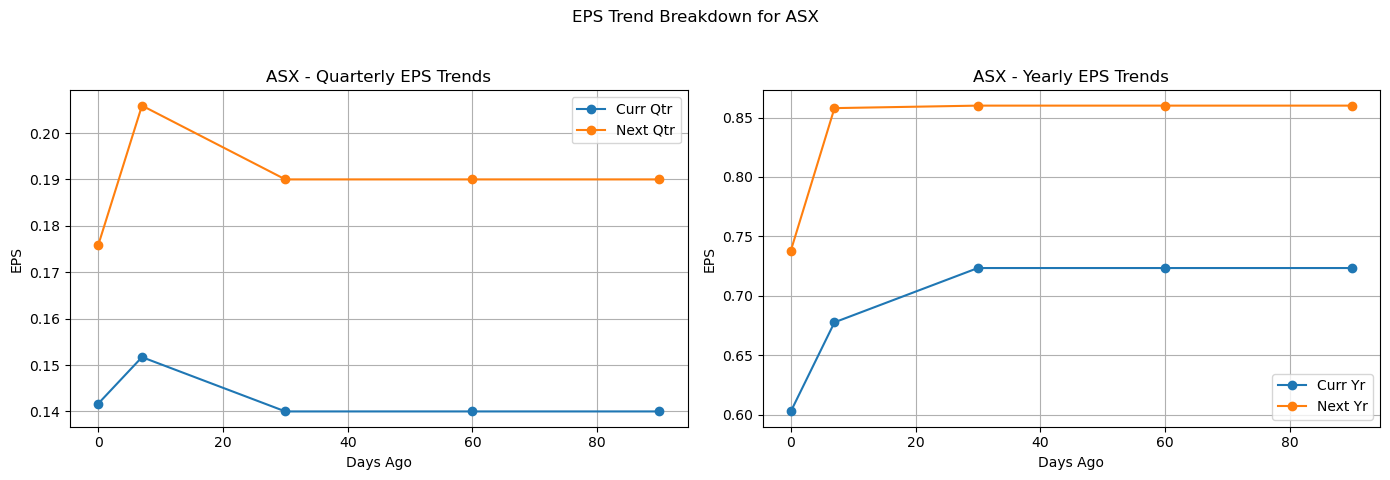

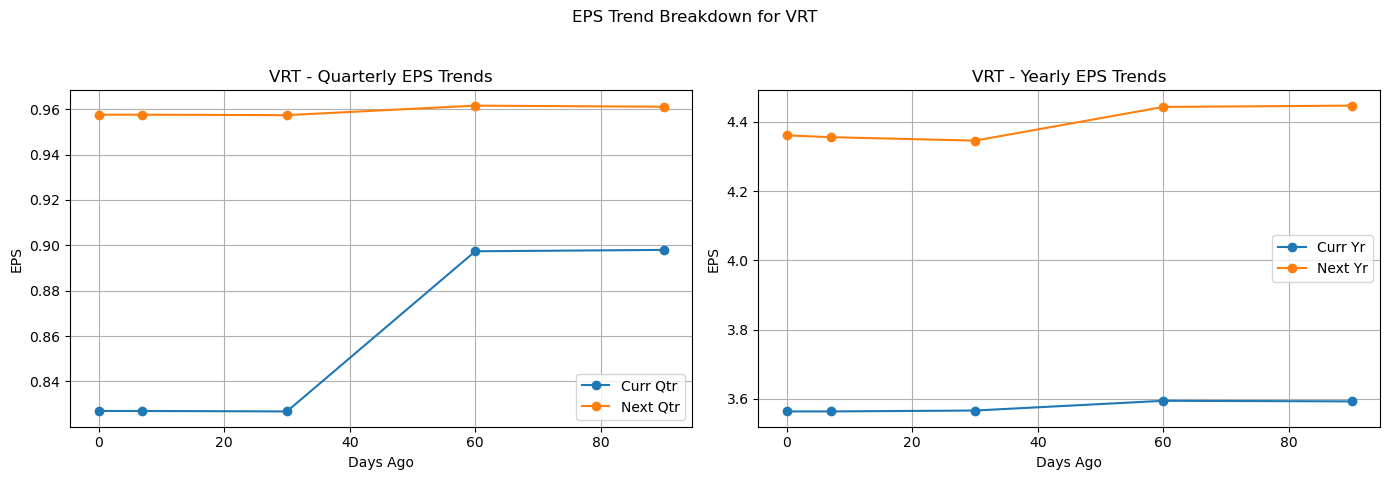

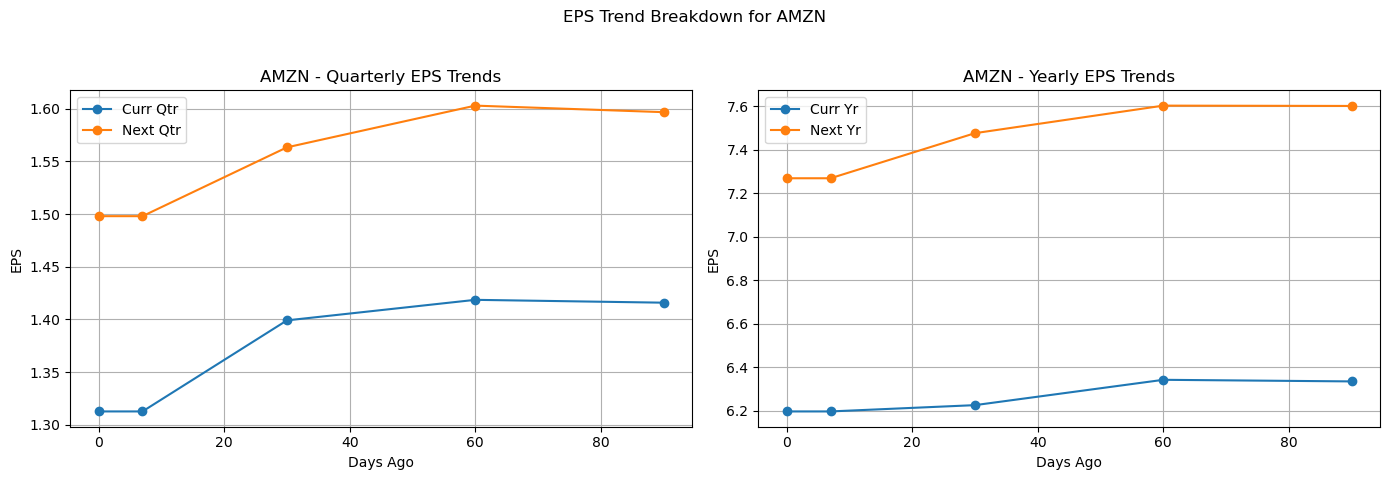

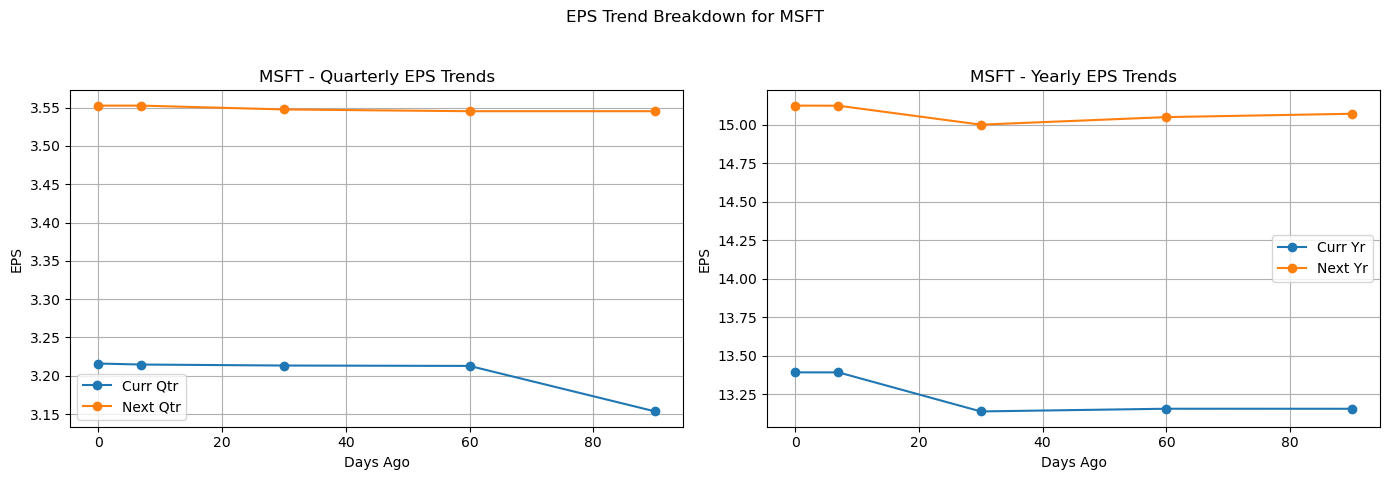

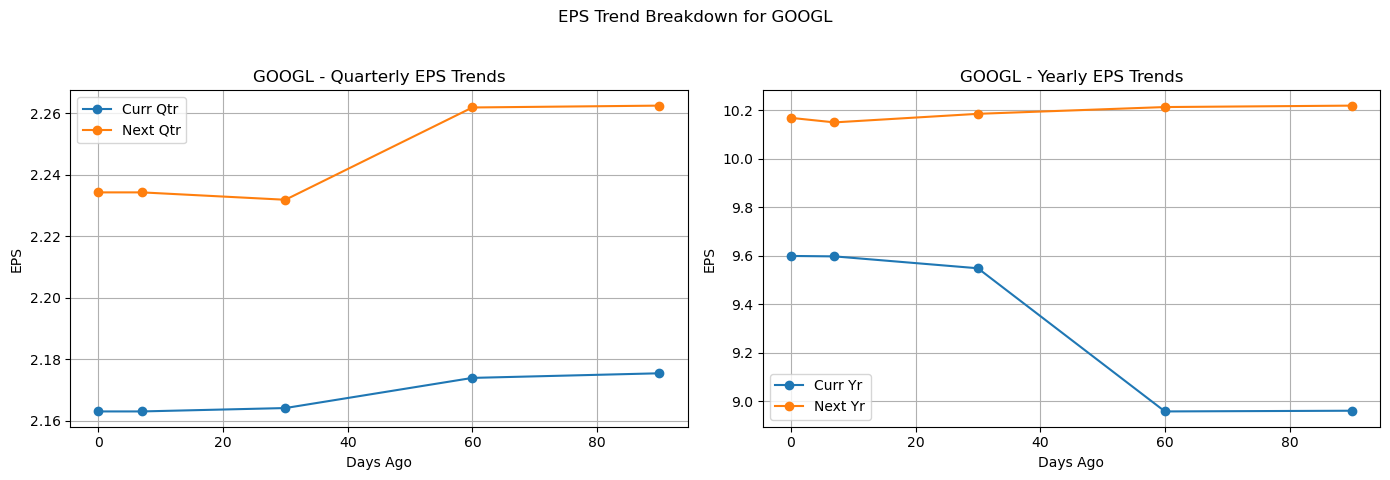

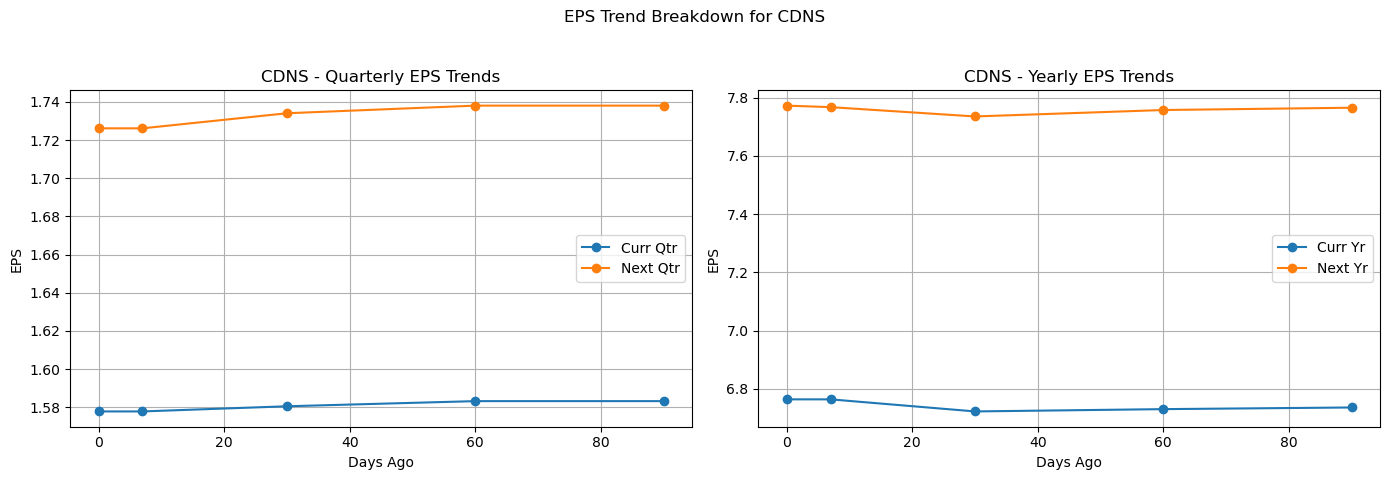

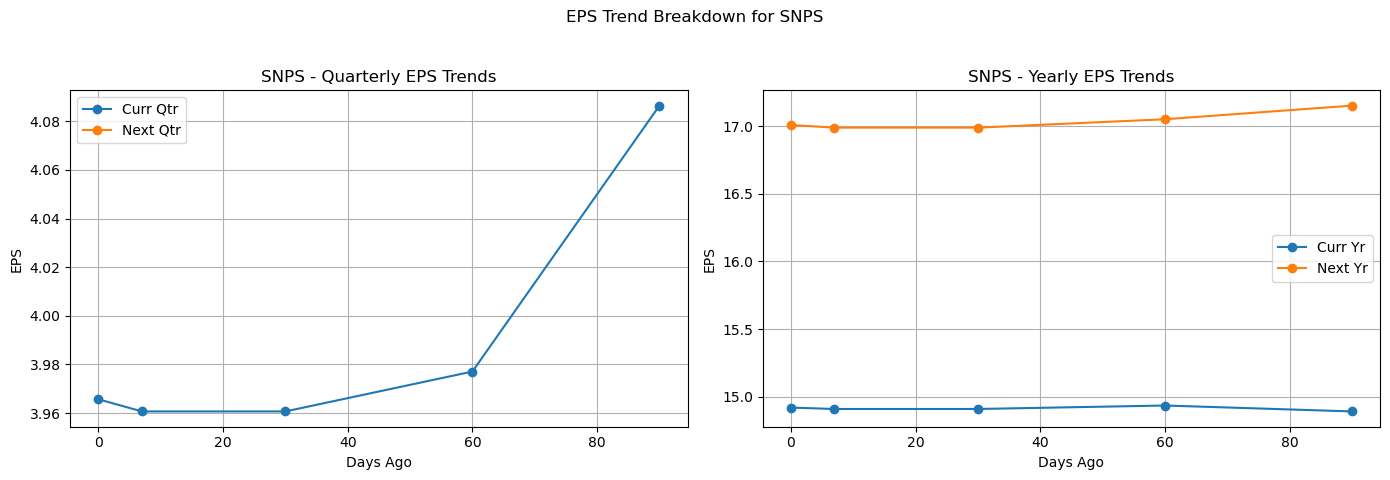

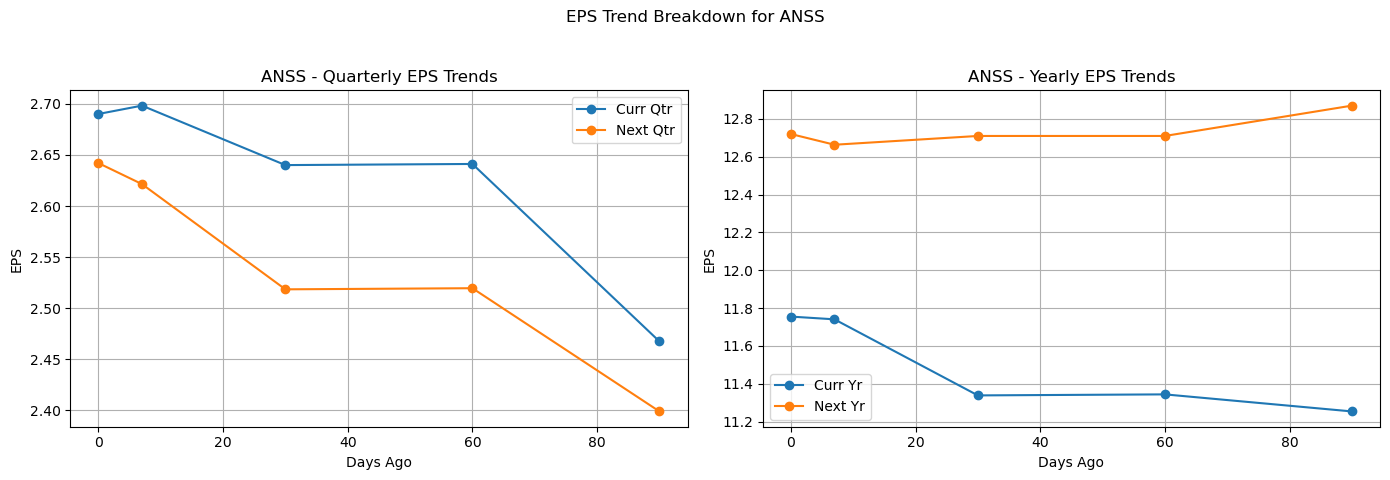

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# 🟩 Functions for calculating slopes and plotting

def calc_slope(row, period):
    y = [
        row.get(f"{period} 90"),
        row.get(f"{period} 60"),
        row.get(f"{period} 30"),
        row.get(f"{period} 7"),
        row.get(f"{period} Curr")
    ]
    x = [90, 60, 30, 7, 0]
    if any(pd.isna(yv) for yv in y):
        return np.nan
    slope, _, _, _, _ = linregress(x, y)
    return slope

def create_slope_heatmap(df):
    periods = ["Curr Qtr", "Next Qtr", "Curr Yr", "Next Yr"]
    for period in periods:
        df[f"{period} Slope"] = df.apply(lambda r: calc_slope(r, period), axis=1)
    
    heatmap_data = df.set_index("Ticker")[[f"{p} Slope" for p in periods]].T
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap="coolwarm", center=0, annot=True, cbar=True,
                 linewidths=0.5, linecolor="grey")
    plt.title("EPS Trend Slopes (90d → Current)")
    plt.xlabel("Ticker")
    plt.ylabel("Period")
    plt.show()
def plot_stock_eps_trends_plotly(row):
    time_points = [90, 60, 30, 7, 0]
    
    # Create subplots (1 row, 2 columns)
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Quarterly EPS Trends", "Yearly EPS Trends"))
    
    # Quarterly EPS Trends
    periods_quarter = ["Curr Qtr", "Next Qtr"]
    for period in periods_quarter:
        eps_values = [
            row.get(f"{period} 90"),
            row.get(f"{period} 60"),
            row.get(f"{period} 30"),
            row.get(f"{period} 7"),
            row.get(f"{period} Curr")
        ]
        fig.add_trace(
            go.Scatter(
                x=time_points,
                y=eps_values,
                mode='lines+markers',
                name=period
            ),
            row=1, col=1
        )
    
    # Yearly EPS Trends
    periods_year = ["Curr Yr", "Next Yr"]
    for period in periods_year:
        eps_values = [
            row.get(f"{period} 90"),
            row.get(f"{period} 60"),
            row.get(f"{period} 30"),
            row.get(f"{period} 7"),
            row.get(f"{period} Curr")
        ]
        fig.add_trace(
            go.Scatter(
                x=time_points,
                y=eps_values,
                mode='lines+markers',
                name=period
            ),
            row=1, col=2
        )
    
    # Layout adjustments
    fig.update_layout(
        title_text=f"EPS Trend Breakdown for {row['Ticker']}",
        height=500,
        width=1000,
        showlegend=True
    )
    
    fig.update_xaxes(title_text="Days Ago", row=1, col=1)
    fig.update_yaxes(title_text="EPS", row=1, col=1)
    fig.update_xaxes(title_text="Days Ago", row=1, col=2)
    fig.update_yaxes(title_text="EPS", row=1, col=2)
    
    fig.show()

# 🟩 Main execution block
if __name__ == "__main__":
    raw1 = [
        # Memory & Storage
        "MU",       # Micron Technology
        # "SSNLF",    # Samsung Electronics (US ADR) / or "005930.KS" for Korean exchange
        # "000660.KS",# SK Hynix (Korean exchange)
        "WDC",      # Western Digital
        "STX",      # Seagate Technology
    
        # Networking & Interconnect
        "MRVL",     # Marvell Technology
        "AVGO",     # Broadcom
        "ANET",     # Arista Networks
        "CSCO",     # Cisco Systems
    
        # Foundries & Manufacturing
        "TSM",      # Taiwan Semiconductor Manufacturing Company
        "ASX",      # ASE Technology
    
        # Data Center Power & Cooling
        "VRT",      # Vertiv
        # "SBGSY",    # Schneider Electric (ADR) / or "SU.PA" for Euronext Paris
    
        # Cloud Providers
        "AMZN",     # Amazon
        "MSFT",     # Microsoft
        "GOOGL",    # Alphabet (Google)
    
        # EDA & Simulation Tools
        "CDNS",     # Cadence Design Systems
        "SNPS",     # Synopsys
        "ANSS"      # Ansys
    ]
    tickers = [f"{t}.US" for t in raw1]
    tbl = build_eps_trends(tickers)
    
    # 🟩 Plot heatmap of slopes for fast overview
    create_slope_heatmap(tbl)
    
    # 🟩 Plot mini line plots for each ticker
    for idx, row in tbl.iterrows():
        plot_stock_eps_trends(row)
